In [7]:
"""
A Keras model for sem seg on PV solar
"""
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from keras import layers
from keras.layers import Input, Dense, Activation, Cropping2D, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, Concatenate
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D, UpSampling2D
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model, to_categorical
from keras.optimizers import Adam
#from FCN_utils import *
from keras.metrics import categorical_accuracy

#from sklearn.metrics import confusion_matrix

import keras.backend as K
K.set_image_data_format('channels_last')
import matplotlib.pyplot as plt

#https://stats.stackexchange.com/questions/285255/nns-multiple-sigmoid-binary-cross-entropy-giving-better-results-than-softmax
#Try with binary crossentropy, cateogrical_accuracy

In [8]:
INPUT_SHAPE = (200,200,14) 
BATCH_SIZE = 12
#N_CLASSES = 7
MAX_ITERATIONS = 100
LEARNING_RATE=5e-7


In [9]:
all_files = glob.glob('./trn_data/*')
print (all_files)

m = len(all_files)

a = np.load(all_files[0])
print (a.files)
print (a['data'].shape)

all_data = np.zeros((m,*a['data'].shape))
all_annotations = np.zeros((m,*a['annotation'].shape))

print (all_data.shape)

ii=0
for f in all_files:
    inp = np.load(f)
    all_data[ii,:,:,:] = inp['data']
    all_annotations[ii,:,:] = inp['annotation']
    ii+=1



print (np.unique(a['annotation']))
print (np.unique(all_annotations))
all_annotations[all_annotations==64.]=0
all_annotations[all_annotations==96.]=0
all_annotations[all_annotations==255]=1

print (np.unique(all_annotations))
print ((a['data']/10000.).clip(0.0,1.0))


['./trn_data/227.npz', './trn_data/77.npz', './trn_data/189.npz', './trn_data/2.npz', './trn_data/67.npz', './trn_data/74.npz', './trn_data/52.npz', './trn_data/103.npz', './trn_data/0.npz', './trn_data/196.npz', './trn_data/222.npz', './trn_data/157.npz', './trn_data/348.npz', './trn_data/96.npz', './trn_data/267.npz', './trn_data/249.npz', './trn_data/36.npz', './trn_data/288.npz', './trn_data/332.npz', './trn_data/350.npz', './trn_data/40.npz', './trn_data/11.npz', './trn_data/322.npz', './trn_data/251.npz', './trn_data/333.npz', './trn_data/314.npz', './trn_data/133.npz', './trn_data/273.npz', './trn_data/60.npz', './trn_data/309.npz', './trn_data/319.npz', './trn_data/20.npz', './trn_data/182.npz', './trn_data/163.npz', './trn_data/147.npz', './trn_data/172.npz', './trn_data/44.npz', './trn_data/190.npz', './trn_data/45.npz', './trn_data/219.npz', './trn_data/39.npz', './trn_data/340.npz', './trn_data/62.npz', './trn_data/329.npz', './trn_data/221.npz', './trn_data/109.npz', './tr

In [10]:

train_images = (all_data/10000.).clip(0.0,1.0)

train_annotations = to_categorical(all_annotations)
N_CLASSES = train_annotations.shape[-1]

print (N_CLASSES)

#train_annotations = to_categorical(train_annotations, num_classes=N_CLASSES)
#N_CLASSES=train_annotations.shape[-1]



2


"\n\ntrain_records, valid_records = read_dataset(os.path.join('6cat'))\nimage_options = {'resize': False, 'resize_size': INPUT_SHAPE[0:1]}\n\nSTEPS_PER_EPOCH = int(len(train_records)/BATCH_SIZE)\n\nprint (STEPS_PER_EPOCH)\n\n#for t in train_records:\n#        t['image'] = '6cat/6cat_final/'+t['image'].split('/')[-1]\n#        t['annotation']='6cat/6cat_final/'+t['image'].split('/')[-1]\n#for v in valid_records:\n#        v['image'] = '6cat/6cat_final/'+v['image'].split('/')[-1]\n#        v['annotation']='6cat/6cat_final/'+v['image'].split('/')[-1]\n\n\nprint (train_records[0:10])\n#input('-->')\n\nselect_records = [\n    '01_ABJ21_F3_0584',\n    '01_ABJ18F4_0267',\n    '11_ABJ18F1J14F4_0308',\n    '00_ABJ18F4_0409',\n    '00_ABJ21_F3_0341',\n    '11_ABJ18F4_0305',\n    '11_ABJ21_F3_0558',\n    '11_ABJ28F2_0296'\n]\n\n\n#train_records = train_records[0:10]*10\n#super duper overfit 1 img\n#trn_recos = {'image':'overfit/img/2003.png','annotation':'overfit/ann/2003.png','filename':'2003'}\

In [13]:
def UNET(input_shape):
    
    inputs = Input(input_shape)


    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs) #200

    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1) #200

    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #200 -> 100


    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'valid', kernel_initializer = 'he_normal')(pool1) #98

    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'valid', kernel_initializer = 'he_normal')(conv2) #96

    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #96 -> 48


    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2) #48

    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3) #48

    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3) #24


    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3) #24
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4) #24
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4) #12

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4) #12
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5) #12
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5)) #24
    merge6 = Concatenate(axis=3)([drop4,up6]) #24,24
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6) #24
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6) #24

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6)) #48
    merge7 = Concatenate(axis=3)([conv3,up7]) #48,48
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7) #48
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7) #48

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = Concatenate(axis=3)([conv2,up8]) #96,96
    inter8a = ZeroPadding2D(padding=(1,1))(merge8) #98
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inter8a) #98
    inter8b = ZeroPadding2D(padding=(1,1))(conv8) #100
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inter8b) #100

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8)) #200
    merge9 = Concatenate(axis=3)([conv1,up9]) #200
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    #conv9 = Conv2D(N_CLASSES, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    #                                          sigmoid
    conv9 = Conv2D(N_CLASSES, 3, activation ='sigmoid', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    #sigmoid probably too strong an activation
    
    model = Model(input = inputs, output = conv9)

    return model

In [17]:
semseg_model = UNET(INPUT_SHAPE)

opt = Adam(lr=1e-5)


semseg_model.compile(optimizer = opt, loss='binary_crossentropy', metrics=[categorical_accuracy])
#This is the right kind of loss - but need to sort the nans out of the loss - maybe the traning data has all-zeros rows? and needs to be one-hot [0 1 0]

#semseg_model.fit(x = train_images, y = train_annotations, epochs = 1, batch_size = BATCH_SIZE)
print (semseg_model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 200, 200, 14) 0                                            
__________________________________________________________________________________________________
conv2d_47 (Conv2D)              (None, 200, 200, 64) 8128        input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_48 (Conv2D)              (None, 200, 200, 64) 36928       conv2d_47[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_9 (MaxPooling2D)  (None, 100, 100, 64) 0           conv2d_48[0][0]                  
__________________________________________________________________________________________________
conv2d_49 

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:62: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


In [18]:
#weighting=np.zeros((200,200,N_CLASSES))
#weighting[:,:,0] = 0.2
#weighting[:,:,1] = 0.8

#sample weighting needs to be recast using the training annotations, and the output needs to be reshaped.
#weighting = (n_annotation,dimx*dimy)@weighting mapped to that class

history = semseg_model.fit(x=train_images, y=train_annotations, validation_split = 0.181818, verbose=1, batch_size=32, epochs=60)
#semseg_model.fit_generator(train_dataset_reader, steps_per_epoch=4, epochs=5, verbose=1, use_multiprocessing=True, workers=4)

Train on 288 samples, validate on 64 samples
Epoch 1/60
288/288 [==============================] - 29s 101ms/step - loss: 8.0079 - categorical_accuracy: 0.4787 - val_loss: 7.9917 - val_categorical_accuracy: 0.7650
Epoch 2/60
288/288 [==============================] - 26s 91ms/step - loss: 7.9774 - categorical_accuracy: 0.7925 - val_loss: 7.9598 - val_categorical_accuracy: 0.8799
Epoch 3/60
288/288 [==============================] - 26s 91ms/step - loss: 7.9506 - categorical_accuracy: 0.7781 - val_loss: 7.9302 - val_categorical_accuracy: 0.9172
Epoch 4/60
288/288 [==============================] - 27s 93ms/step - loss: 4.8275 - categorical_accuracy: 0.9103 - val_loss: 1.0014 - val_categorical_accuracy: 0.9620
Epoch 5/60
288/288 [==============================] - 27s 93ms/step - loss: 0.6988 - categorical_accuracy: 0.9626 - val_loss: 0.5524 - val_categorical_accuracy: 0.9698
Epoch 6/60
288/288 [==============================] - 27s 92ms/step - loss: 0.5734 - categorical_accuracy: 0.9699 

{'val_loss': [0.27747032046318054, 0.22657489776611328, 0.19936026632785797, 0.18832790851593018, 0.18469160795211792, 0.17378850281238556, 0.16712360084056854, 0.16141027957201004, 0.15987681597471237, 0.1581263318657875, 0.15346845239400864, 0.15230470895767212, 0.16391921788454056, 0.15316910296678543, 0.16747203469276428, 0.1660960465669632, 0.15085671842098236, 0.14613518863916397, 0.1469801962375641, 0.13940676674246788], 'val_categorical_accuracy': [0.963043749332428, 0.9643574357032776, 0.9652585983276367, 0.9667644500732422, 0.9684925675392151, 0.9715773463249207, 0.9733371138572693, 0.9746839702129364, 0.9766995906829834, 0.9779757857322693, 0.9793062508106232, 0.9797953069210052, 0.9799308776855469, 0.9799933433532715, 0.9800042808055878, 0.9800413846969604, 0.9800785183906555, 0.9800976514816284, 0.9801082015037537, 0.9801171720027924], 'loss': [0.29326824016041225, 0.26041949954297805, 0.22748600277635786, 0.2231073925892512, 0.20319808522860208, 0.1951623558998108, 0.1859

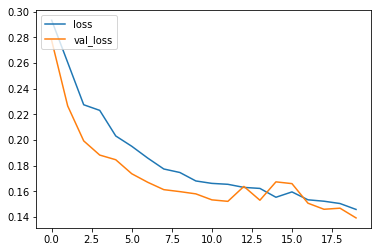

In [16]:
print (history.history)
epochs = np.arange(len(history.history['val_loss']))
plt.plot(epochs, history.history['loss'], label='loss')
plt.plot(epochs, history.history['val_loss'], label='val_loss')
plt.legend(loc='upper left')
plt.show()

In [11]:
train_images_sample = train_images[60:100,:,:,:]
train_annotations_sample = train_annotations[60:100,:,:,:]

In [12]:
prediction = semseg_model.predict(x=train_images_sample)

In [13]:
print(prediction.shape)
print (train_annotations_sample.shape)
print (train_annotations_sample[2,100,25,:])
print (prediction[2,100,25,:])

(40, 200, 200, 2)
(40, 200, 200, 2)
[1. 0.]
[9.9953210e-01 6.8158895e-04]


In [14]:
def save_image(arr, fname):
    #print (arr, arr.shape)
    #arr = arr.astype('uint8')
    if (len(arr.shape)>2):
        gamma = 2.5
        
        im = Image.fromarray((arr*gamma*255.).clip(0,255).astype('uint8'))
        im.save(fname)
    else:
        #im should have scalars in 
        im = Image.fromarray((arr*40).astype('uint8'))
        plt.imshow(im)
        plt.show()
        im.save(fname)

(40, 200, 200, 2)
(40, 200, 200)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


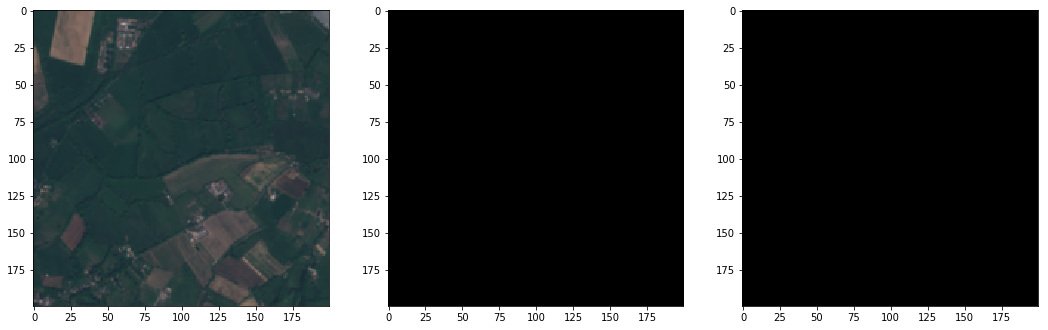

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]]


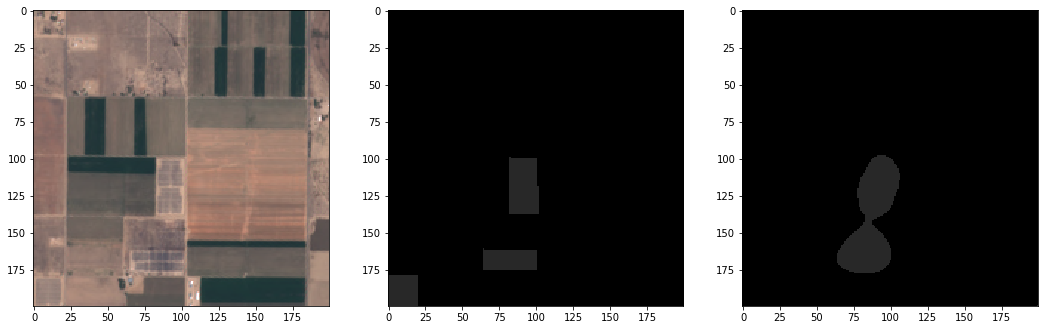

[[1 1 1 ... 0 0 0]
 [0 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


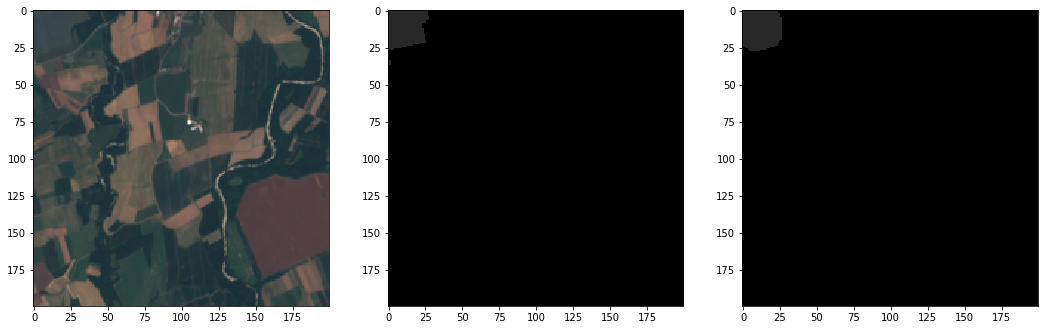

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]]


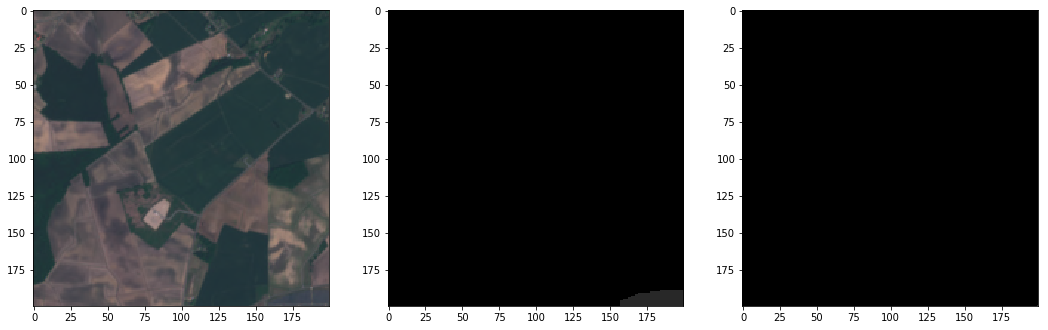

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


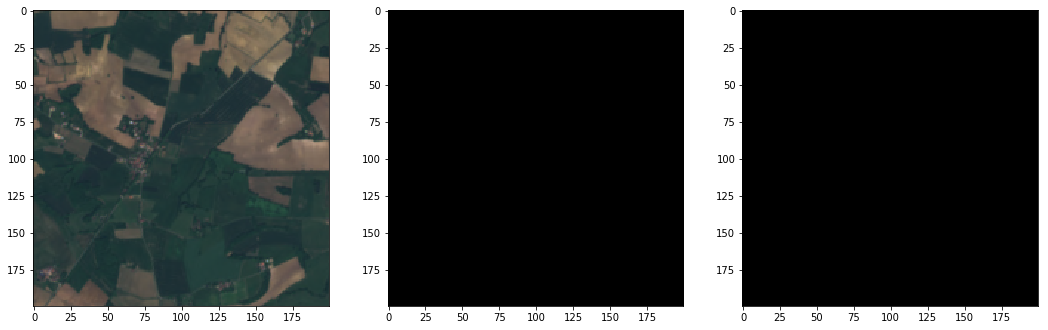

[[0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 1 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 1 1]]


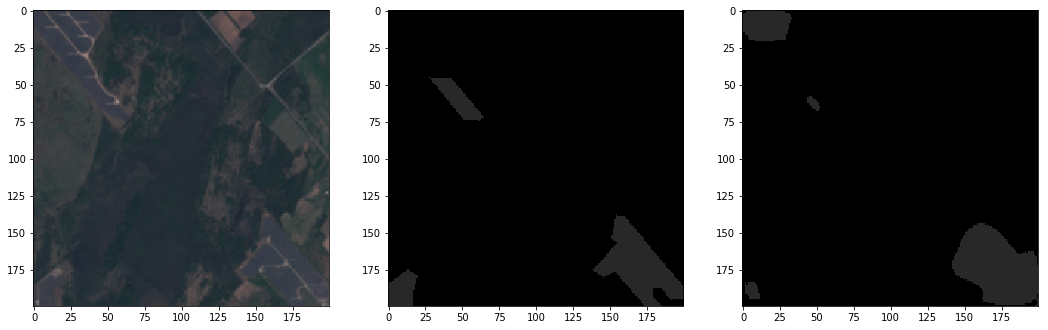

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


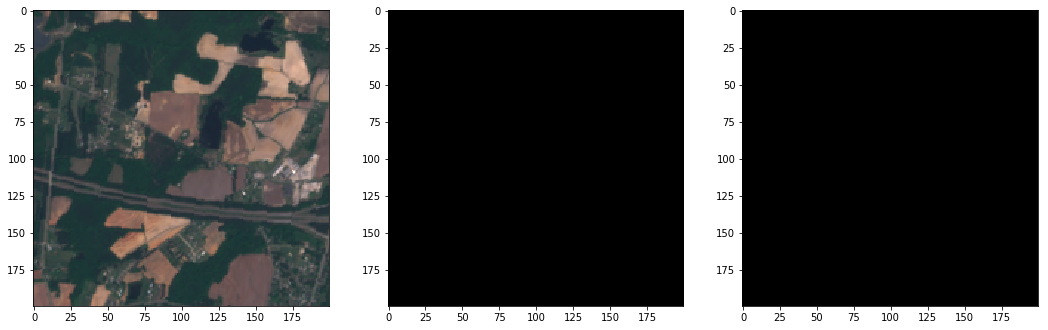

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


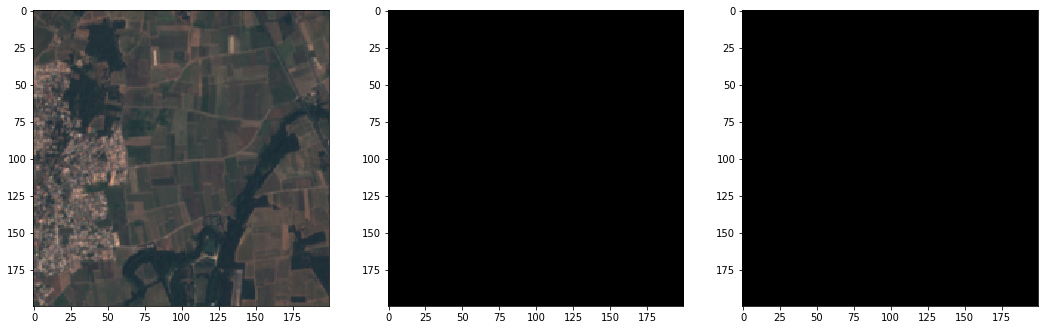

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]]


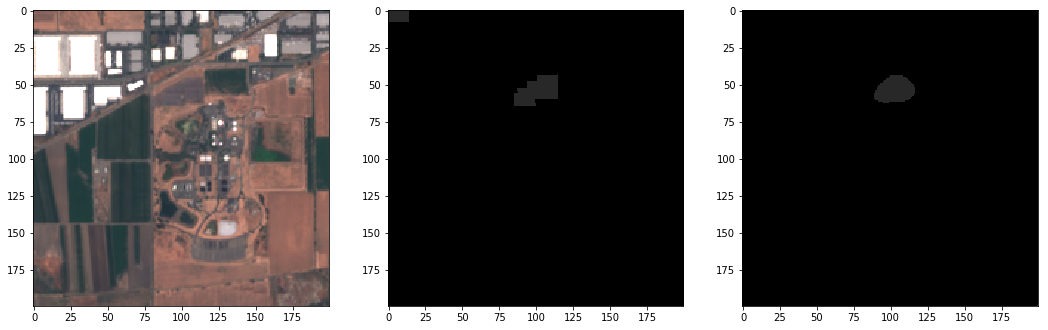

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


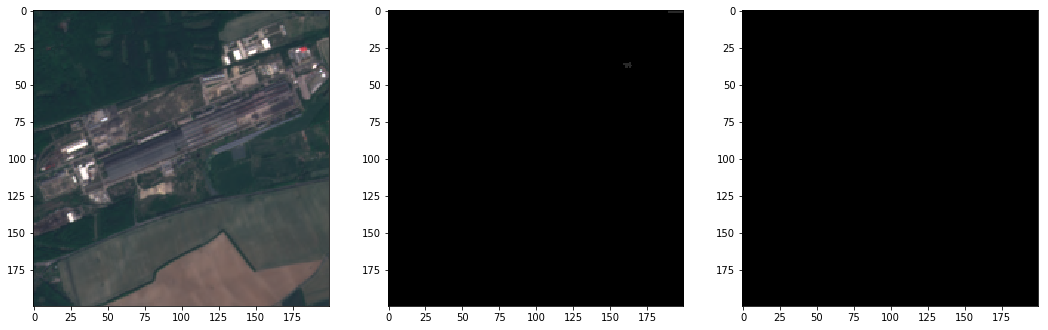

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


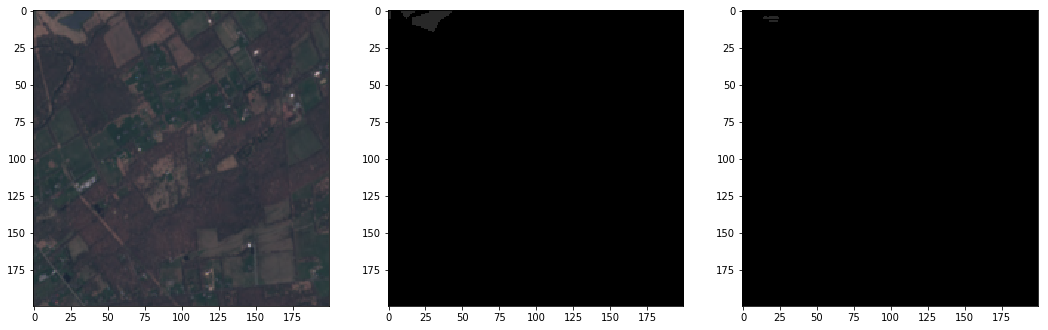

[[0 0 0 ... 0 1 1]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


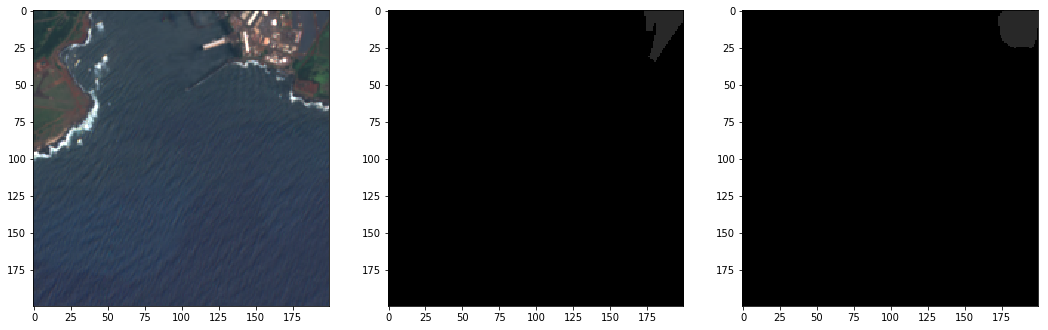

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


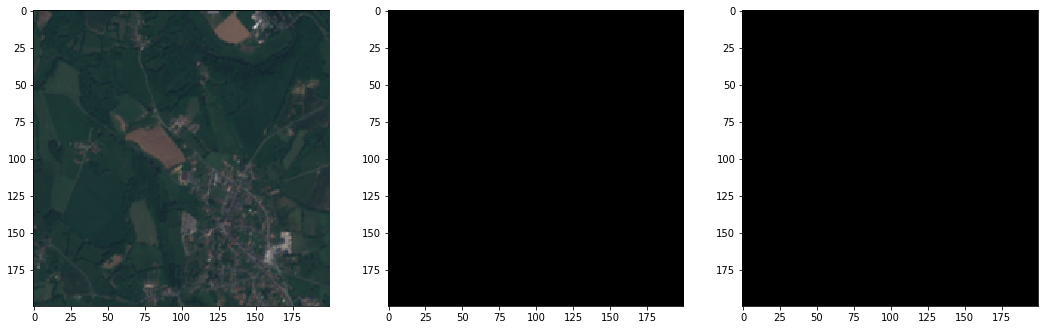

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


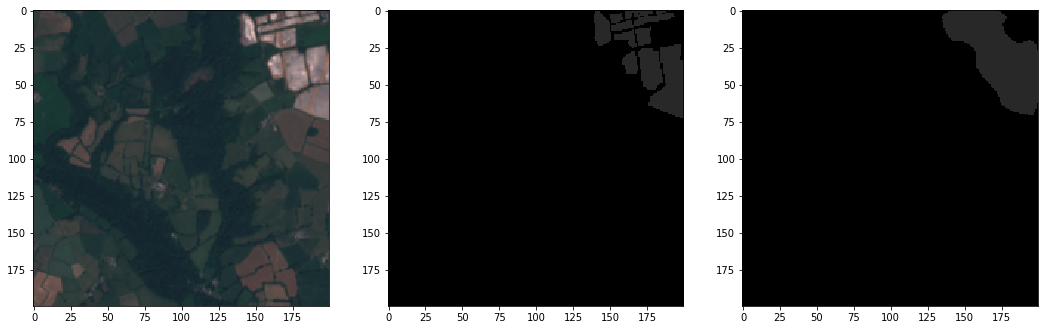

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


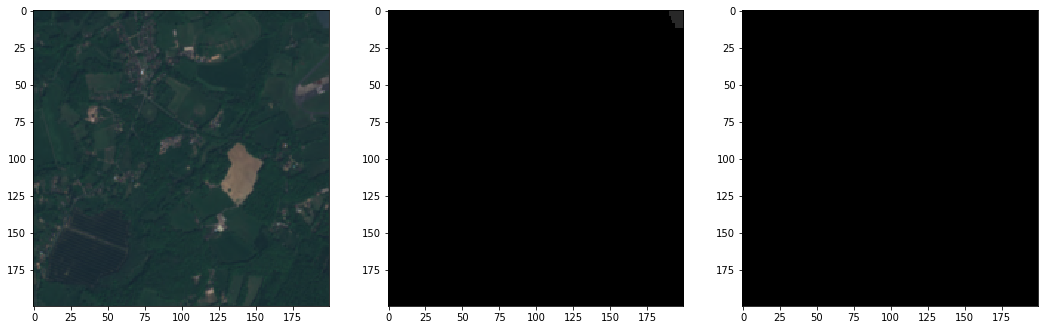

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 1 1]]


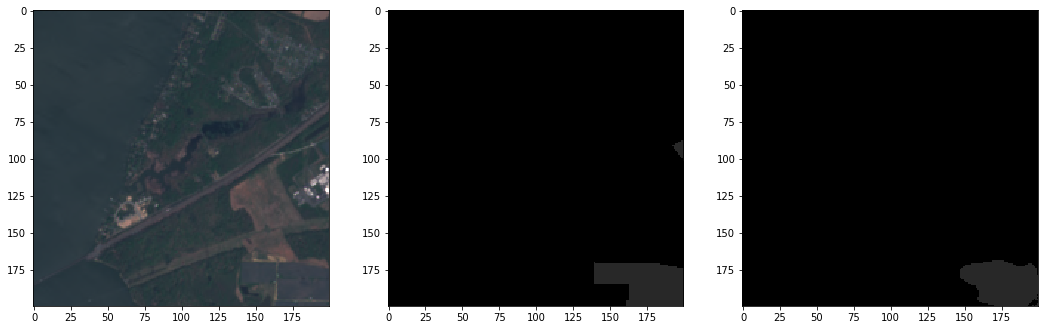

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


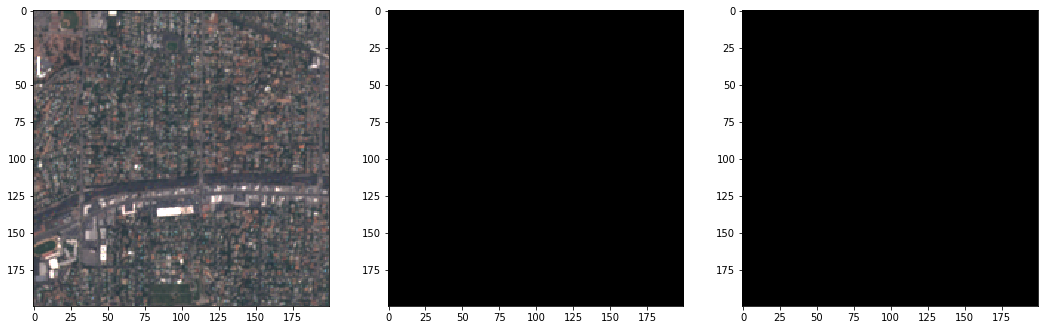

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


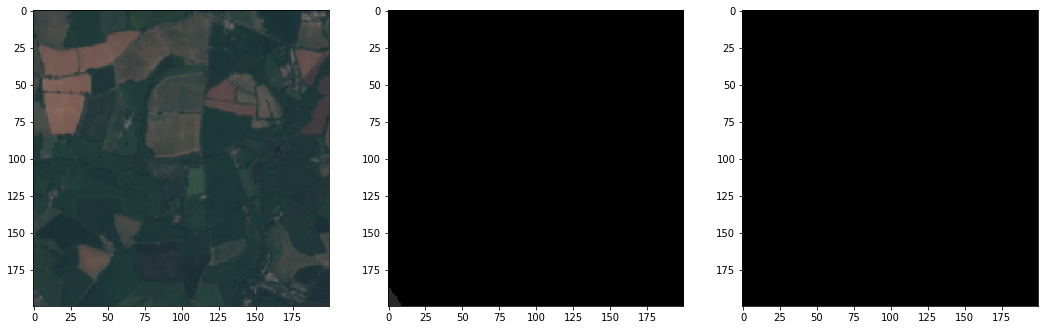

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


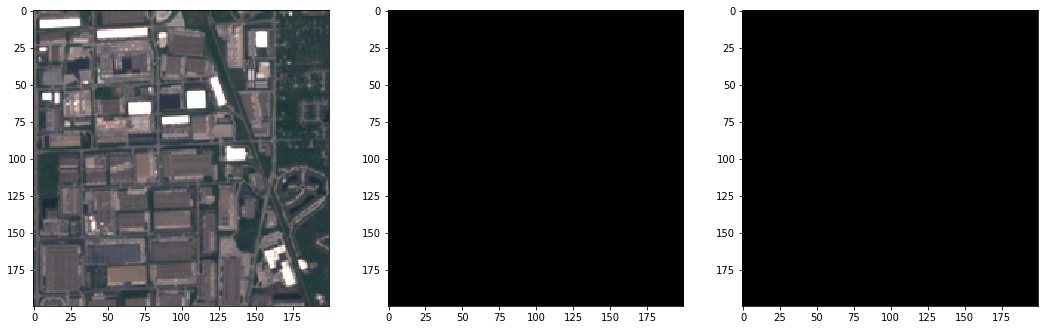

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]]


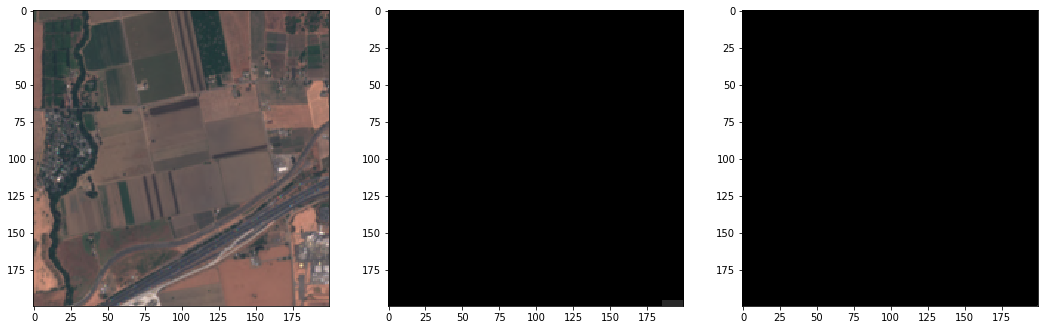

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


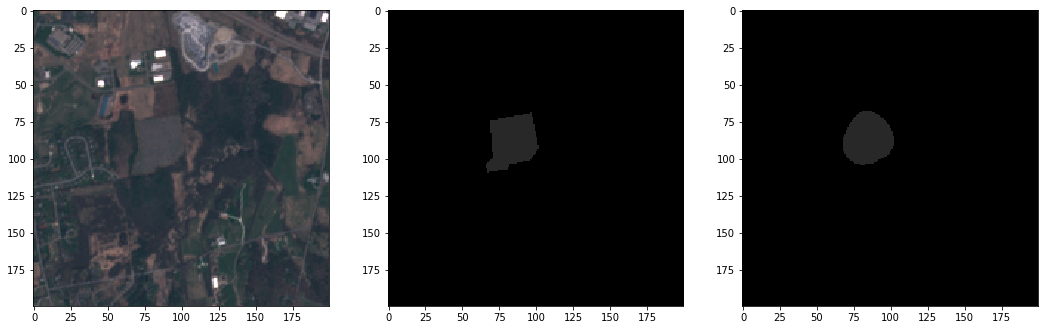

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


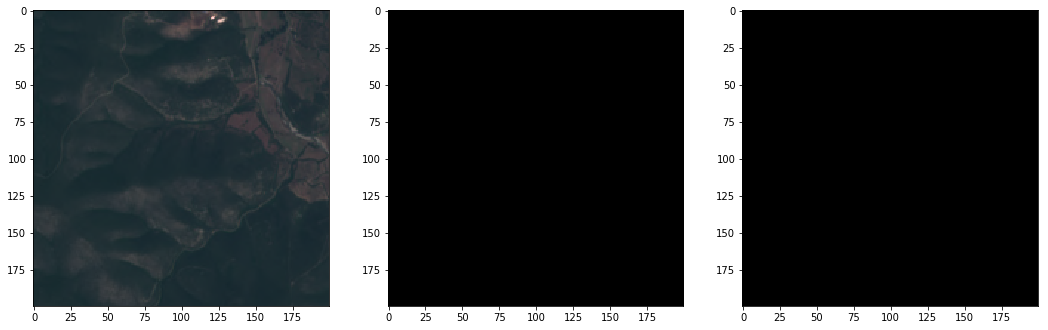

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


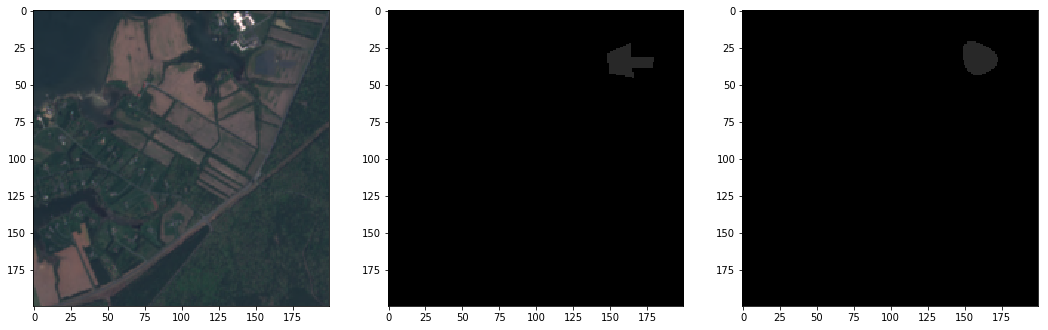

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]]


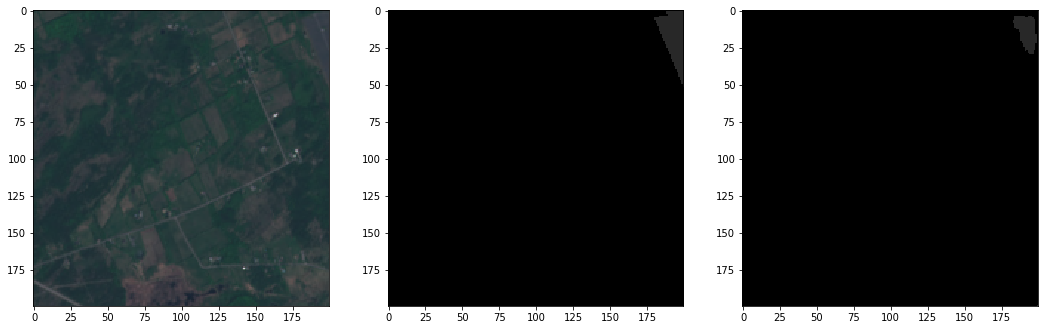

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


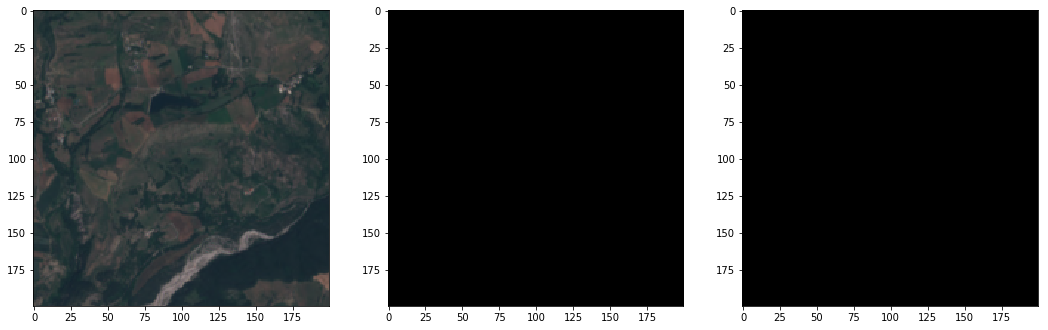

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]]


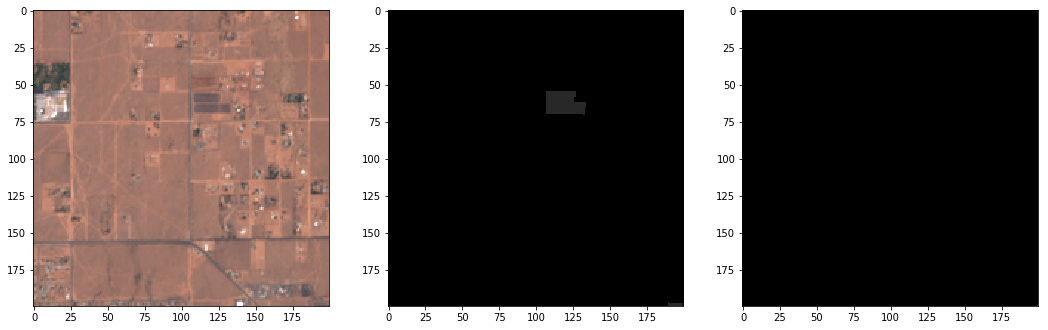

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]]


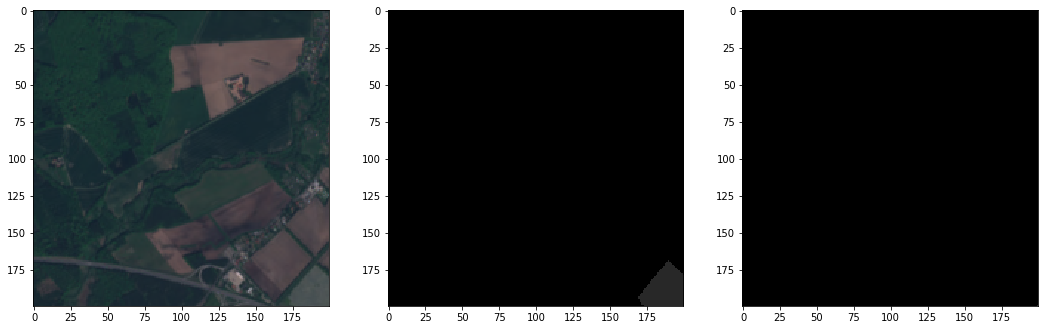

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


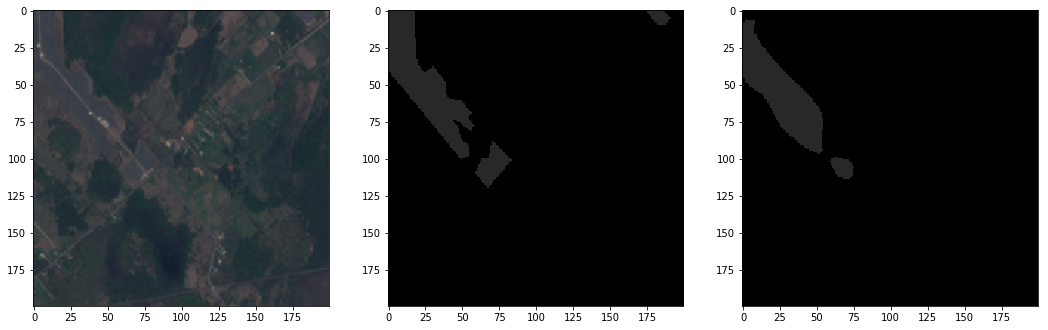

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


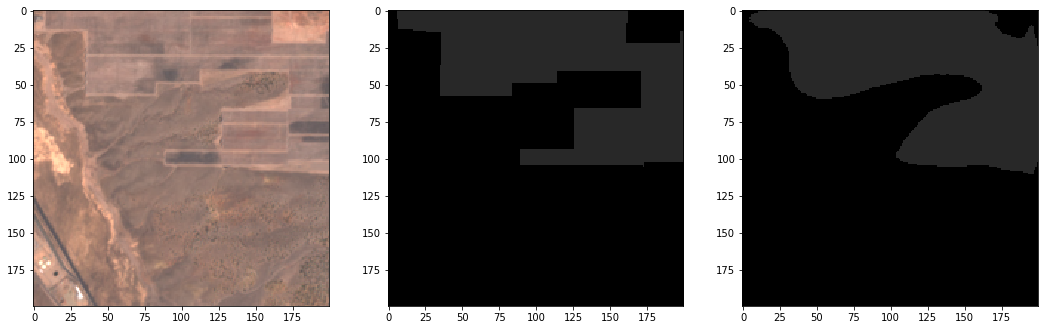

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


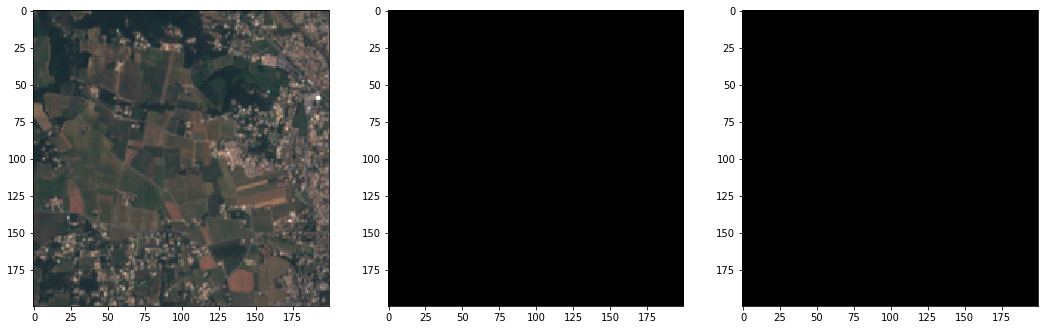

[[0 0 0 ... 0 1 1]
 [0 0 0 ... 1 0 1]
 [0 0 0 ... 1 1 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


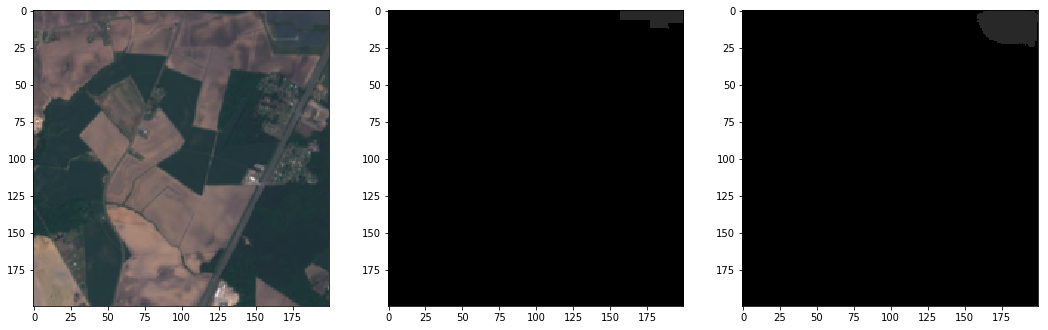

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 1]]


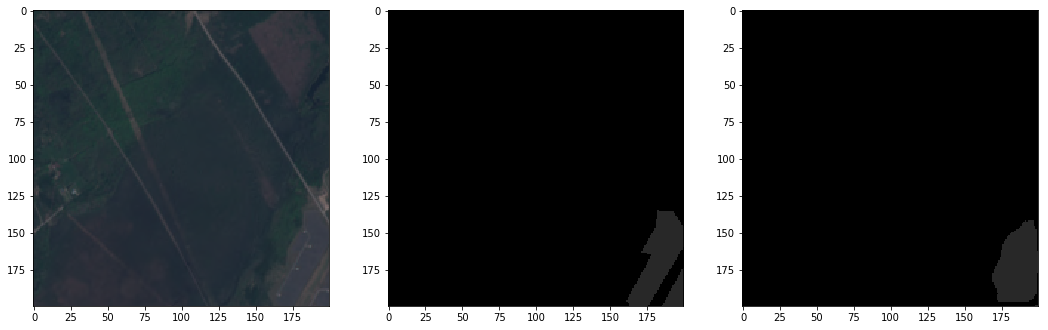

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]]


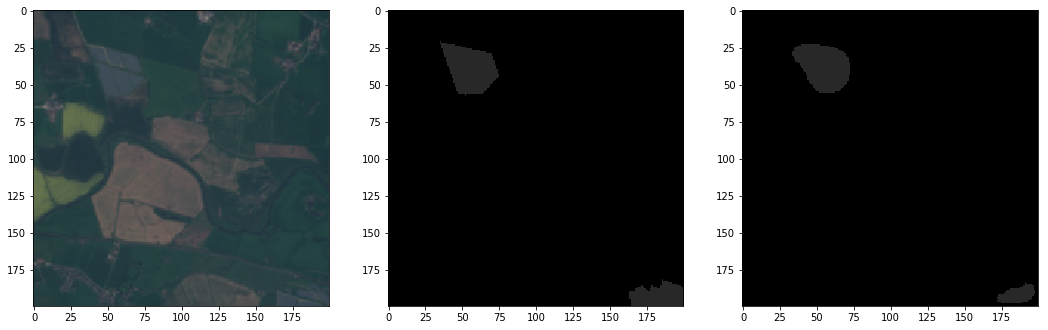

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]]


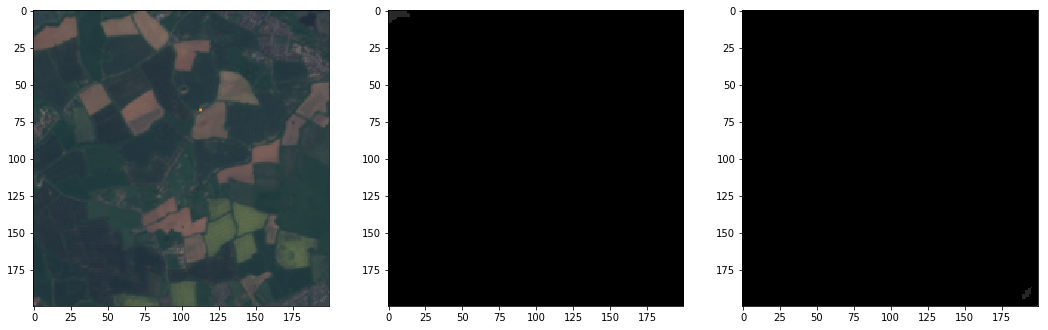

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 1 1 1]]


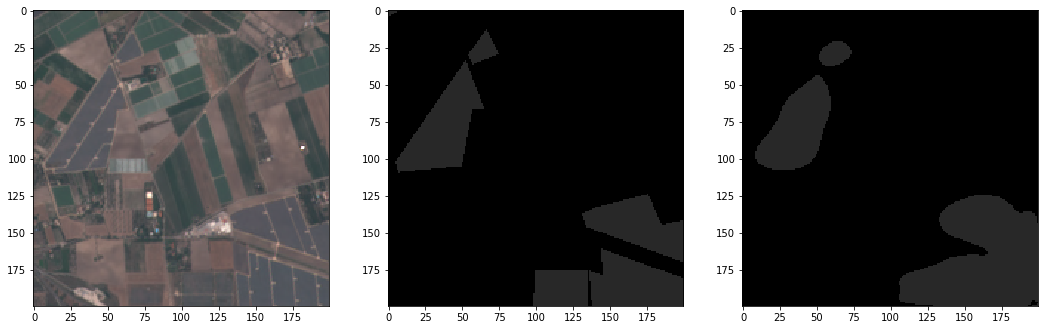

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


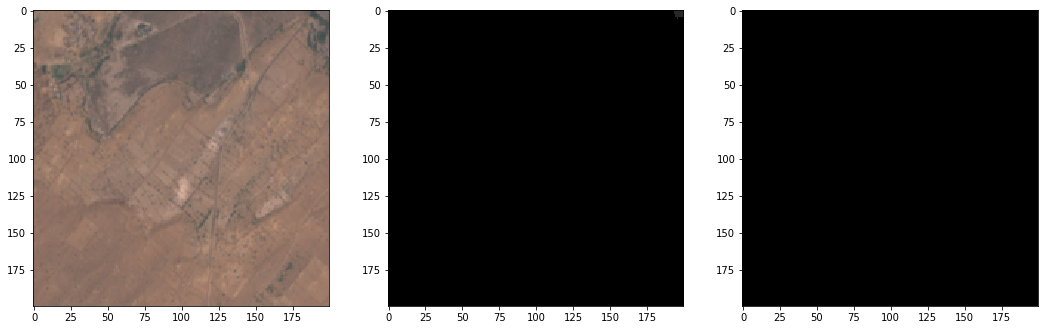

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


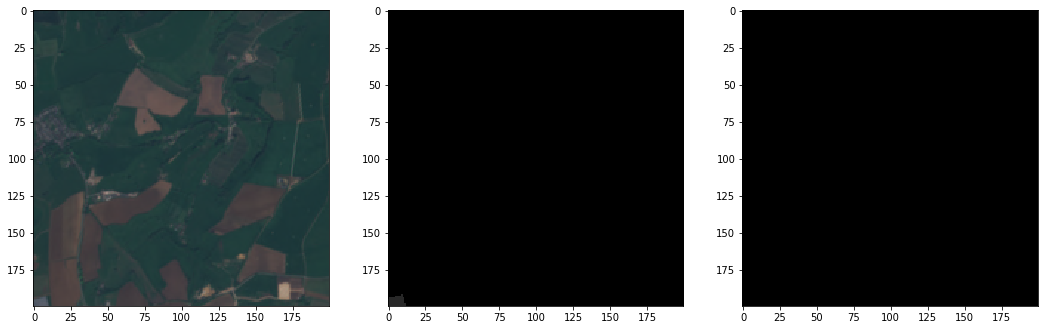

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


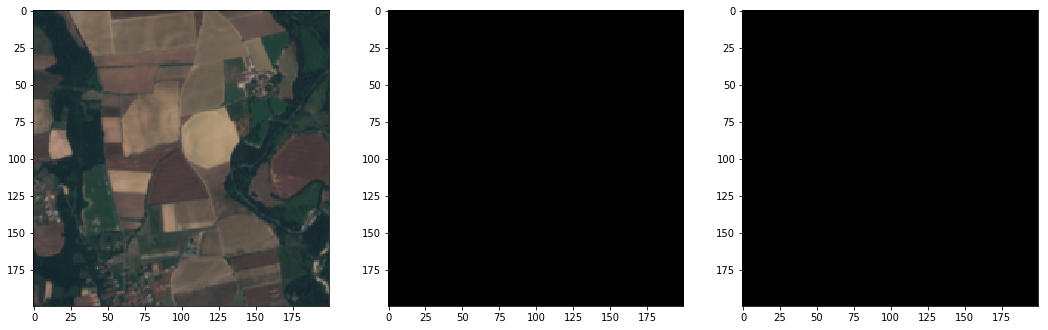

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


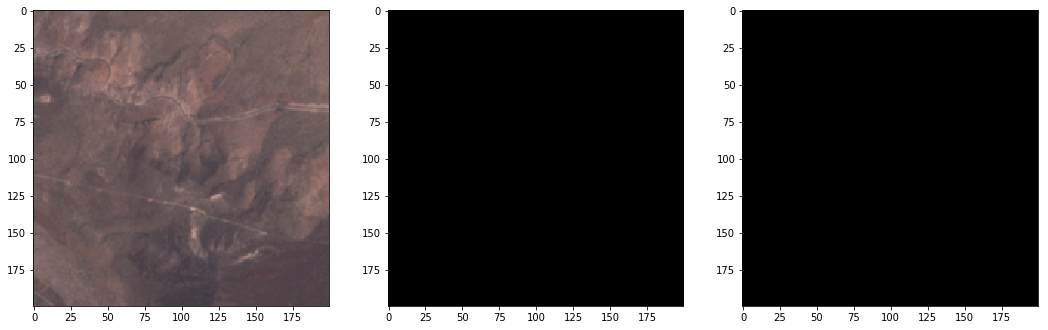

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


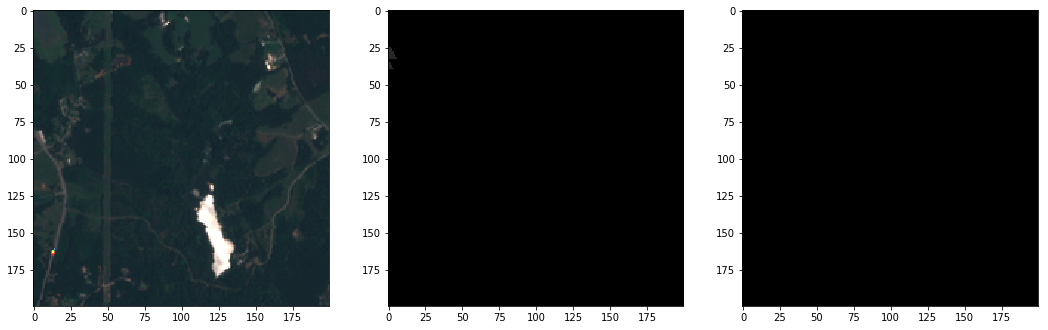

In [15]:
print (prediction.shape)
prediction_out = np.argmax(prediction,axis=-1)
print (prediction_out.shape)

for i in range(40):
    gamma = 2.5
    #save_image(np.argmax(prediction[i,:,:,:], axis=2), 'sample_out/sample_'+'_'+str(i)+'_PRED.png')
    #save_image(train_images_sample[i,:,:,0:3], 'sample_out/sample_'+'_'+str(i)+'_INPUT.png')
    #save_image(np.argmax(train_annotations_sample[i,:,:,:], axis=2), 'sample_out/sample_'+'_'+str(i)+'_TRUE.png')
    fig, axs = plt.subplots(1,3, figsize=(18,27))
    axs[0].imshow(Image.fromarray((train_images_sample[i,:,:,0:3]*gamma*255.).clip(0,255).astype('uint8')))
    axs[1].imshow(Image.fromarray((np.argmax(train_annotations_sample[i,:,:,:], axis=2)*40).astype('uint8')))
    axs[2].imshow(Image.fromarray((np.argmax(prediction[i,:,:,:], axis=2)*40).astype('uint8')))
    #axs[2].imshow(Image.fromarray((prediction[i,:,:,2]*23).astype('uint8')))
    print (np.argmax(prediction[i,:,:,:],axis=2))
    plt.show()
    
    
    
    

In [16]:
def IoU(prediction, annotation):
    #prediciton and annotation should have the same shape: (m,w,l,n_c)
    n_c = annotation.shape[-1]
    prediction = np.argmax(prediction, axis=-1)
    annotation = np.argmax(annotation, axis=-1)
    intersections = {}
    unions = {}
    for c in range(n_c):
        prediction_c = prediction==c
        annotation_c = annotation==c
        #intersection = AND(a,b) = a*b
        #union = OR(a,b) = a+b
        intersection_c = prediction_c*annotation_c
        union_c = prediction_c+annotation_c
        intersections[c] = np.sum(intersection_c)
        unions[c] = np.sum(union_c)
    return intersections, unions

In [17]:
intersections, unions = IoU(prediction,train_annotations_sample)

for c,v in intersections.items():
    print ('for class ',c,' IoU was ',float(v)/unions[c])

for class  0  IoU was  0.9909775681348396
for class  1  IoU was  0.6802636628366329


In [31]:
def conf_mat(prediction, annotation):
    #prediciton and annotation should have the same shape: (m,w,l,n_c)
    n_c = annotation.shape[-1]
    total = annotation.shape[0]*annotation.shape[1]*annotation.shape[2]
    prediction = np.argmax(prediction, axis=-1)
    annotation = np.argmax(annotation, axis=-1)
    out_mat = np.zeros((n_c,n_c))
    for c_1 in range(n_c):
        #print (c_1)
        prediction_c = prediction==c_1
        for c_2 in range(n_c):
            annotation_c = annotation==c_2
            total_c = np.sum(annotation_c)
            out_mat[c_1,c_2] = np.round(np.sum(prediction_c*annotation_c)/total_c,2)
    return out_mat
            

In [32]:
conf_mat = conf_mat(prediction,train_annotations_sample)
print (conf_mat)

[[0.89 0.31 0.25 0.28 0.29 0.13 0.  ]
 [0.01 0.17 0.06 0.05 0.   0.01 0.  ]
 [0.   0.   0.01 0.   0.   0.   0.  ]
 [0.1  0.49 0.04 0.62 0.27 0.03 0.  ]
 [0.   0.   0.   0.01 0.41 0.   0.  ]
 [0.01 0.03 0.17 0.04 0.04 0.83 0.  ]
 [0.   0.   0.47 0.   0.   0.   1.  ]]


In [33]:

weights = semseg_model.get_weights()
print (len(weights))
for w in weights:
    print(w.shape)



np.savez(open('weights.npz','wb'),weights)

46
(3, 3, 3, 64)
(64,)
(3, 3, 64, 64)
(64,)
(3, 3, 64, 128)
(128,)
(3, 3, 128, 128)
(128,)
(3, 3, 128, 256)
(256,)
(3, 3, 256, 256)
(256,)
(3, 3, 256, 512)
(512,)
(3, 3, 512, 512)
(512,)
(3, 3, 512, 1024)
(1024,)
(3, 3, 1024, 1024)
(1024,)
(2, 2, 1024, 512)
(512,)
(3, 3, 1024, 512)
(512,)
(3, 3, 512, 512)
(512,)
(2, 2, 512, 256)
(256,)
(3, 3, 512, 256)
(256,)
(3, 3, 256, 256)
(256,)
(2, 2, 256, 128)
(128,)
(3, 3, 256, 128)
(128,)
(3, 3, 128, 128)
(128,)
(2, 2, 128, 64)
(64,)
(3, 3, 128, 64)
(64,)
(3, 3, 64, 64)
(64,)
(3, 3, 64, 7)
(7,)


In [34]:
from keras.models import model_from_json

# serialize model to JSON
model_json = semseg_model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)


In [6]:
"""bring these FCN utils over here"""
#https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly.html


import os
import glob
import pickle
import numpy as np
from scipy import ndimage, misc
from keras.utils import plot_model, to_categorical, Sequence


def read_dataset(data_dir):
    pickle_filename = "result.pickle"
    pickle_filepath = os.path.join(data_dir, pickle_filename)
    if not os.path.exists(pickle_filepath):

        result = create_image_lists(os.path.join(data_dir))
        print (result)
        print ("Pickling ...")
        with open(pickle_filepath, 'wb') as f:
            pickle.dump(result, f, pickle.HIGHEST_PROTOCOL)
    else:
        print ("Found pickle file!")

    with open(pickle_filepath, 'rb') as f:
        result = pickle.load(f)
        training_records = result['training']
        for t in training_records:
            t['image'] = '6cat/'+t['image']
            t['annotation']='6cat/'+t['annotation']
        validation_records = result['validation']
        for v in validation_records:
            v['image'] = '6cat/'+v['image']
            v['annotation']='6cat/'+v['annotation']
        del result

    return (training_records, validation_records)


class BatchDatset(Sequence):
    files = []
    images = []
    annotations = []
    image_options = {}
    batch_offset = 0
    epochs_completed = 0

    def __init__(self, records_list, image_options={}, BATCH_SIZE=12,N_CLASSES=7):
        """
        Intialize a generic file reader with batching for list of files
        :param records_list: list of file records to read -
        sample record: {'image': f, 'annotation': annotation_file, 'filename': filename}
        :param image_options: A dictionary of options for modifying the output image
        Available options:
        resize = True/ False
        resize_size = #size of output image - does bilinear resize
        color=True/False
        """
        print("Initializing Batch Dataset Reader...")
        print(image_options)
        self.files = records_list
        self.batch_files = records_list
        self.batch_files_sub = []
        self.image_options = image_options
        self.batch_size = BATCH_SIZE
        self.n_classes = N_CLASSES
        #self._read_images()

    def _read_images(self):
        self.__channels = True
        self.images = np.array([self._transform(filename['image']) for filename in self.files])
        self.__channels = False
        self.annotations = np.array(
            [np.expand_dims(self._transform(filename['annotation']), axis=3) for filename in self.files])
        self.annotations = np.squeeze((np.arange(9) == self.annotations[...,None]-1).astype(int))
        print (self.images.shape)
        print (self.annotations.shape)

    def _read_images_sub(self):
        #print (self.batch_files_sub)
        self.__channels = True
        self.images = np.array([self._transform(filename['image']) for filename in self.batch_files_sub])
        self.__channels = False
        self.annotations = np.array(
            [self._transform(filename['annotation']) for filename in self.batch_files_sub])
        #print (self.images.shape)
        print (self.annotations.shape)

    def _transform(self, filename):
        image = misc.imread(filename)
        if self.__channels and len(image.shape) < 3:  # make sure images are of shape(h,w,3)
            image = np.array([image for i in range(3)])

        if self.image_options.get("resize", False) and self.image_options["resize"]:
            resize_size = int(self.image_options["resize_size"])
            resize_image = misc.imresize(image,
                                         [resize_size, resize_size], interp='nearest')
        else:
            resize_image = image

        return np.array(resize_image)

    def get_records(self):
        return self.images, self.annotations

    def reset_batch_offset(self, offset=0):
        self.batch_offset = offset

    def next_batch(self):
        start = self.batch_offset
        self.batch_offset += self.batch_size
        if self.batch_offset > self.images.shape[0]:
            # Finished epoch
            self.epochs_completed += 1
            print("****************** Epochs completed: " + str(self.epochs_completed) + "******************")
            # Shuffle the data
            perm = np.arange(self.images.shape[0])
            np.random.shuffle(perm)
            self.images = self.images[perm]
            self.annotations = self.annotations[perm]
            # Start next epoch
            start = 0
            self.batch_offset = self.batch_size

        end = self.batch_offset
        return self.images[start:end], self.annotations[start:end]

    def __data_generator(self):
        start = self.batch_offset
        self.batch_offset += self.batch_size
        if self.batch_offset > len(self.batch_files):
            # Finished epoch
            self.epochs_completed += 1
            print("****************** Epochs completed: " + str(self.epochs_completed) + "******************")
            # Shuffle the data
            perm = np.arange(len(self.batch_files))
            np.random.shuffle(perm)
            self.batch_files = [self.batch_files[i] for i in list(perm)]
            # Start next epoch
            start = 0
            self.batch_offset = self.batch_size

        end = self.batch_offset
        self.batch_files_sub = self.batch_files[start:end]
        #print (self.batch_files_sub)
        self._read_images_sub()
        self.annotations = to_categorical(self.annotations, num_classes=self.n_classes)
        
        return self.images, self.annotations

    def get_random_batch(self, batch_size):
        indexes = np.random.randint(0, self.images.shape[0], size=[batch_size]).tolist()
        return self.images[indexes], self.annotations[indexes]